In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/koi_cumulative.csv', comment='#')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['koi_disposition'].value_counts()}")

Dataset shape: (9564, 49)
Class distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


## Program 5: Naive Bayes Classification — Exoplanet Candidate Vetting

**Scientific Background:**  
Naive Bayes is a probabilistic classifier based on Bayes' theorem:

$$P(\text{CONFIRMED} | \text{features}) = \frac{P(\text{features} | \text{CONFIRMED}) \cdot P(\text{CONFIRMED})}{P(\text{features})}$$

It assumes all features are **conditionally independent** given the class label —
the "naive" assumption. In reality, exoplanet features like transit depth and
planet radius are physically correlated, so this assumption is violated.

This makes Naive Bayes an important **baseline and contrast** in our paper:
we can quantify how much performance is lost when feature correlations are ignored.

**Gaussian NB** assumes each feature follows a normal distribution within each class.

In [2]:
data = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
data['label'] = (data['koi_disposition'] == 'CONFIRMED').astype(int)

features = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
            'koi_model_snr', 'koi_steff', 'koi_slogg', 'koi_srad',
            'koi_prad', 'koi_teq']

data = data[features + ['label']].dropna()
print(f"Usable rows: {len(data)}")
print(f"CONFIRMED: {sum(data['label']==1)} | FALSE POSITIVE: {sum(data['label']==0)}")

X = data[features].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Naive Bayes doesn't strictly need scaling but helps with numerical stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Usable rows: 7326
CONFIRMED: 2744 | FALSE POSITIVE: 4582


In [3]:
model = GaussianNB()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("=" * 50)
print("        NAIVE BAYES RESULTS")
print("=" * 50)
print(f"  Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"  ROC-AUC  : {auc:.4f}")
print("=" * 50)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred,
      target_names=['FALSE POSITIVE', 'CONFIRMED']))

# Class means learned by model (original scale for interpretation)
print("\nLearned Class Means (scaled space):")
for i, cls in enumerate(['FALSE POSITIVE', 'CONFIRMED']):
    print(f"\n  {cls}:")
    for feat, mean in zip(features, model.theta_[i]):
        print(f"    {feat:20s}: {mean:+.4f}")

        NAIVE BAYES RESULTS
  Accuracy : 0.7101 (71.01%)
  ROC-AUC  : 0.8802

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.97      0.55      0.70       917
     CONFIRMED       0.57      0.97      0.72       549

      accuracy                           0.71      1466
     macro avg       0.77      0.76      0.71      1466
  weighted avg       0.82      0.71      0.71      1466


Learned Class Means (scaled space):

  FALSE POSITIVE:
    koi_period          : +0.1221
    koi_impact          : +0.0568
    koi_duration        : +0.1386
    koi_depth           : +0.1882
    koi_model_snr       : +0.1610
    koi_steff           : +0.1728
    koi_slogg           : -0.1400
    koi_srad            : +0.0676
    koi_prad            : +0.0195
    koi_teq             : +0.2162

  CONFIRMED:
    koi_period          : -0.2038
    koi_impact          : -0.0948
    koi_duration        : -0.2314
    koi_depth           : -0.3142
    koi_model_

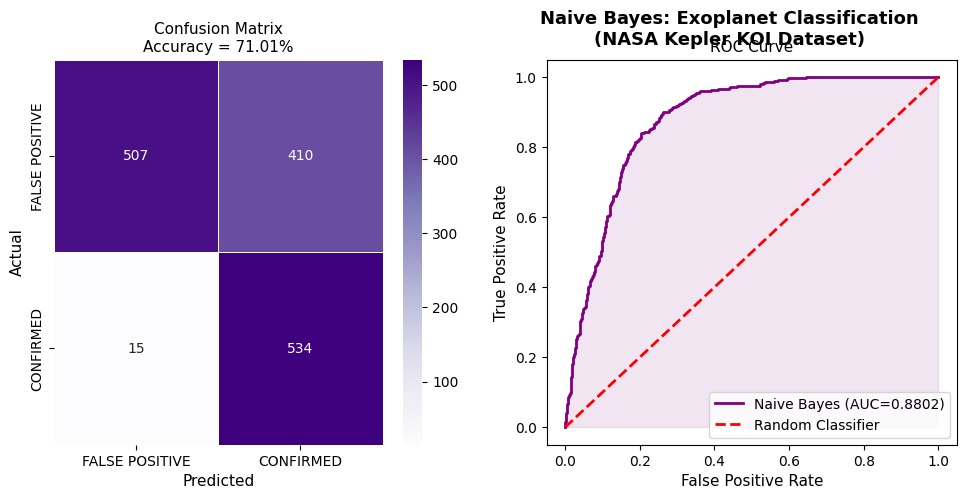

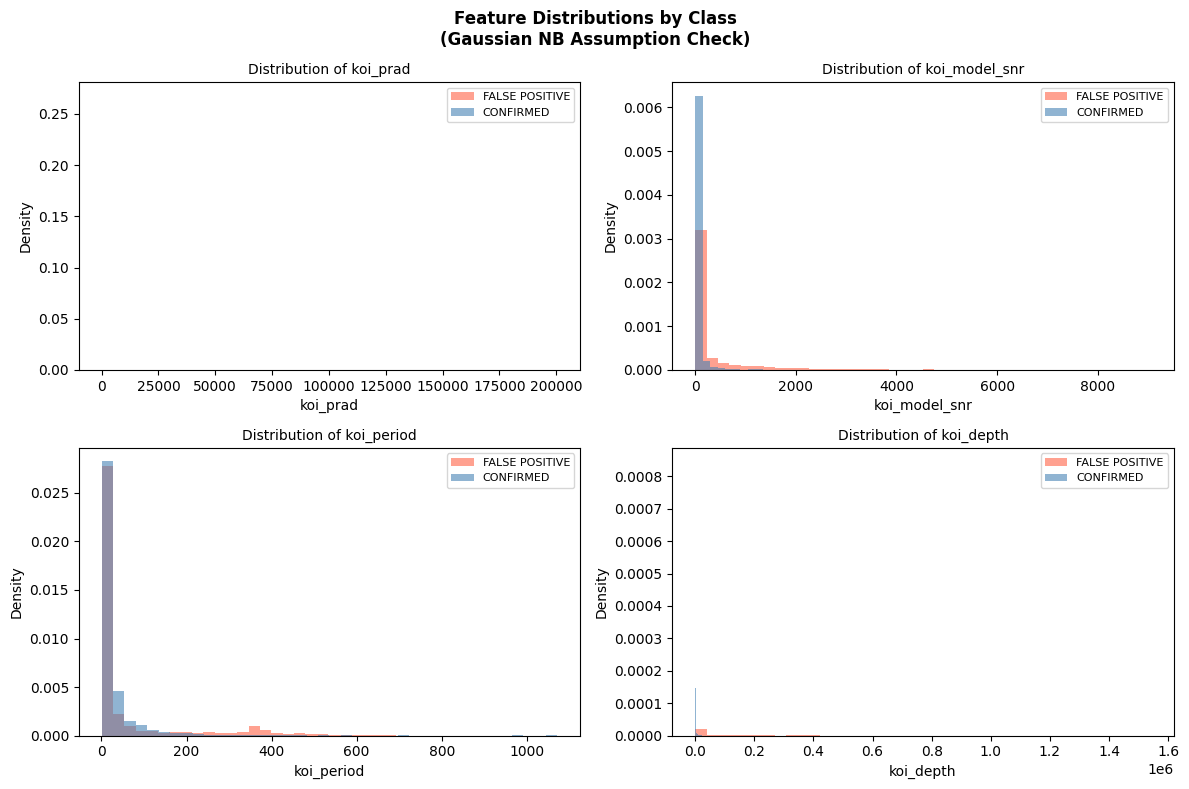

Plots saved!


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Naive Bayes: Exoplanet Classification\n(NASA Kepler KOI Dataset)',
             fontsize=13, fontweight='bold')

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0],
            xticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            yticklabels=['FALSE POSITIVE', 'CONFIRMED'],
            linewidths=0.5)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_title(f'Confusion Matrix\nAccuracy = {acc*100:.2f}%', fontsize=11)

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, color='purple', lw=2, label=f'Naive Bayes (AUC={auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='purple')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=11)
axes[1].legend(loc='lower right')

# Plot 3: Feature distributions per class (top 4 features)
top_features = ['koi_prad', 'koi_model_snr', 'koi_period', 'koi_depth']
axes[2].set_visible(False)
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 8))
fig2.suptitle('Feature Distributions by Class\n(Gaussian NB Assumption Check)',
              fontsize=12, fontweight='bold')

for ax, feat in zip(axes2.flat, top_features):
    confirmed = data.loc[data['label']==1, feat]
    fp = data.loc[data['label']==0, feat]
    ax.hist(fp, bins=40, alpha=0.6, color='tomato', label='FALSE POSITIVE', density=True)
    ax.hist(confirmed, bins=40, alpha=0.6, color='steelblue', label='CONFIRMED', density=True)
    ax.set_xlabel(feat, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'Distribution of {feat}', fontsize=10)
    ax.legend(fontsize=8)

plt.tight_layout()
fig.savefig('../outputs/plots/05_naive_bayes_roc.png', dpi=150, bbox_inches='tight')
fig2.savefig('../outputs/plots/05_naive_bayes_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plots saved!")

In [5]:
print("Naive Bayes: Scientific Interpretation")
print("=" * 55)
print(f"""
Naive Bayes applies Bayes' theorem with a strong independence
assumption between all features.

Results vs previous models:
  • Logistic Regression : ~74% accuracy
  • Decision Tree       : ~87% accuracy  
  • Naive Bayes         : {acc*100:.2f}% accuracy  ← today

Why Naive Bayes struggles here:
  Exoplanet features are physically correlated:
  • koi_prad and koi_depth are mathematically linked
    (deeper transit → larger planet radius)
  • koi_steff and koi_teq are physically linked
    (hotter star → hotter planet equilibrium temp)

  Naive Bayes treats these as independent, which is
  physically incorrect — hence the performance gap.

ROC-AUC = {auc:.4f}: The model still has meaningful
discriminative ability despite the naive assumption,
suggesting the features themselves are highly informative.

This result demonstrates WHY model selection matters:
the same data gives dramatically different results
depending on the algorithm's underlying assumptions.
""")

Naive Bayes: Scientific Interpretation

Naive Bayes applies Bayes' theorem with a strong independence
assumption between all features.

Results vs previous models:
  • Logistic Regression : ~74% accuracy
  • Decision Tree       : ~87% accuracy  
  • Naive Bayes         : 71.01% accuracy  ← today

Why Naive Bayes struggles here:
  Exoplanet features are physically correlated:
  • koi_prad and koi_depth are mathematically linked
    (deeper transit → larger planet radius)
  • koi_steff and koi_teq are physically linked
    (hotter star → hotter planet equilibrium temp)

  Naive Bayes treats these as independent, which is
  physically incorrect — hence the performance gap.

ROC-AUC = 0.8802: The model still has meaningful
discriminative ability despite the naive assumption,
suggesting the features themselves are highly informative.

This result demonstrates WHY model selection matters:
the same data gives dramatically different results
depending on the algorithm's underlying assumptions.
